<a href="https://colab.research.google.com/github/Laaliji/Movies_Recommandation_System/blob/main/Clustering_Based_Recommandation_System2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Préparation de l'environnement**

In [2]:
import pandas as pd  # Pour gérer les datasets sous forme de DataFrames
import numpy as np   # Pour les opérations numériques et la gestion des tableaux
# Importation des modules scikit-learn pour les tâches d'apprentissage automatique
from sklearn.cluster import KMeans  # Pour le clustering K-Means
from sklearn.decomposition import PCA  # Pour la réduction de dimensionnalité
from sklearn.metrics import precision_score, recall_score, mean_absolute_error  # Pour les métriques d'évaluation
from sklearn.model_selection import KFold  # Pour la validation croisée
from sklearn.metrics.pairwise import cosine_distances  # Pour calculer la métrique de diversité
import seaborn as sns
from collections import Counter
import datetime
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import csv
import os
from scipy.sparse import csr_matrix
# Importation de scipy pour les opérations sur matrices creuses
from scipy.sparse import csr_matrix  # Pour une représentation efficace des matrices creuses
# Importation de matplotlib pour la visualisation
import matplotlib.pyplot as plt  # Pour tracer les visualisations des clusters

# Montage de Google Drive pour accéder au dataset
from google.colab import drive
drive.mount('/content/drive')
# Définition du chemin de base pour le dataset
base_path = '/content/drive/My Drive/Movies Dataset/'
contents = os.listdir(base_path)
print(contents)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['genome_scores.csv', 'movie.csv', 'rating.csv', 'link.csv', 'genome_tags.csv', 'tag.csv', 'dbscan_cluster_plot.png', 'movies_with_clusters.csv', 'cluster_plot_k4_no_titles.png']


In [3]:
try:
    # First, let's inspect the movie.csv file to determine the correct delimiter
    with open(base_path + 'movie.csv', 'r', encoding='utf-8') as file:
        sample = file.read(1000)  # Read first 1000 characters to detect format
        print("Sample of movie.csv file:")
        print(sample)

    # Try loading with comma as delimiter first (most common)
    try:
        movie_df = pd.read_csv(base_path + 'movie.csv',
                              quoting=csv.QUOTE_MINIMAL,
                              escapechar='\\',
                              encoding='utf-8')
        print("Successfully loaded movie.csv using comma as delimiter")
    except Exception as e:
        print(f"Error with comma delimiter: {e}")
        # If comma doesn't work, try with semicolon and additional options
        movie_df = pd.read_csv(base_path + 'movie.csv',
                              sep=';',
                              quoting=csv.QUOTE_MINIMAL,
                              escapechar='\\',
                              encoding='utf-8',
                              error_bad_lines=False)  # Skip problematic lines

    # Try to load other files with appropriate settings
    genome_scores_df = pd.read_csv(base_path + 'genome_scores.csv')
    genome_tags_df = pd.read_csv(base_path + 'genome_tags.csv')
    links_df = pd.read_csv(base_path + 'link.csv')
    ratings_df = pd.read_csv(base_path + 'rating.csv')
    tag_df = pd.read_csv(base_path + 'tag.csv')

    # Configuration de la graine aléatoire pour la reproductibilité
    np.random.seed(42)

except FileNotFoundError as e:
    print(f"Erreur : Fichiers du dataset non trouvés. {e}")
    print("Vérifiez le base_path et assurez-vous que les fichiers existent.")
except Exception as e:
    print(f"Une erreur inattendue s'est produite: {e}")

Sample of movie.csv file:
"movieId","title","genres"
1,"Toy Story (1995)","Adventure|Animation|Children|Comedy|Fantasy"
2,"Jumanji (1995)","Adventure|Children|Fantasy"
3,"Grumpier Old Men (1995)","Comedy|Romance"
4,"Waiting to Exhale (1995)","Comedy|Drama|Romance"
5,"Father of the Bride Part II (1995)","Comedy"
6,"Heat (1995)","Action|Crime|Thriller"
7,"Sabrina (1995)","Comedy|Romance"
8,"Tom and Huck (1995)","Adventure|Children"
9,"Sudden Death (1995)","Action"
10,"GoldenEye (1995)","Action|Adventure|Thriller"
11,"American President, The (1995)","Comedy|Drama|Romance"
12,"Dracula: Dead and Loving It (1995)","Comedy|Horror"
13,"Balto (1995)","Adventure|Animation|Children"
14,"Nixon (1995)","Drama"
15,"Cutthroat Island (1995)","Action|Adventure|Romance"
16,"Casino (1995)","Crime|Drama"
17,"Sense and Sensibility (1995)","Drama|Romance"
18,"Four Rooms (1995)","Comedy"
19,"Ace Ventura: When Nature Calls (1995)","Comedy"
20,"Money Train (1995)","Action|Comedy|Crime|Drama|Thriller"
21,"Get S

# **Analyse Exploratoire des données**

In [4]:
# Print basic information for each DataFrame
for df, name in [(movie_df, "Movies"), (ratings_df, "Ratings"), (tag_df, "Tags"),
                 (genome_scores_df, "Genome Scores"), (genome_tags_df, "Genome Tags"),
                 (links_df, "Links")]:
    print(f"\n{'-'*50}")
    print(f"{name} DataFrame Analysis:")
    print(f"{'-'*50}")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nSample Data:")
    print(df.head())
    print()


--------------------------------------------------
Movies DataFrame Analysis:
--------------------------------------------------
Shape: (27278, 3)

Data Types:
movieId     int64
title      object
genres     object
dtype: object

Missing Values:
movieId    0
title      0
genres     0
dtype: int64

Sample Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


--------------------------------------------------
Ratings DataFrame Analysis:
------------

- La table des films est bien structurée, avec des données complètes et prêtes pour l'extraction de caractéristiques comme les années (via title) et les genres (via genres). La diversité des genres indique un potentiel pour analyser des tendances ou regrouper des films par style.
- La grande quantité de notes sans données manquantes est idéale pour construire des systèmes de recommandation (filtrage collaboratif) ou analyser les tendances des notes par utilisateur ou film. Les horodatages permettent d’explorer l’évolution des préférences au fil du temps.
- Les étiquettes (tags) offrent un aperçu des perceptions subjectives des utilisateurs, mais leur nature non standardisée (38 643 étiquettes uniques, d’après l’EDA précédente) suggère une forte dispersion. Elles sont utiles pour enrichir les profils de films, mais nécessitent un nettoyage (normalisation, filtrage des étiquettes rares).
- Les scores de génome offrent une description standardisée et quantitative des films, idéale pour le clustering ou les recommandations basées sur le contenu. Leur densité (11,7 millions de scores) et l’absence de données manquantes en font une ressource clé pour capturer les caractéristiques des films.
- Cette table est utile pour enrichir les données avec des informations externes (ex. : métadonnées IMDb), mais les 252 valeurs manquantes pour tmdbId limitent légèrement son utilisation sans nettoyage. Elle est moins centrale pour l’EDA interne mais précieuse pour des analyses étendues.


=== MOVIE ANALYSIS ===


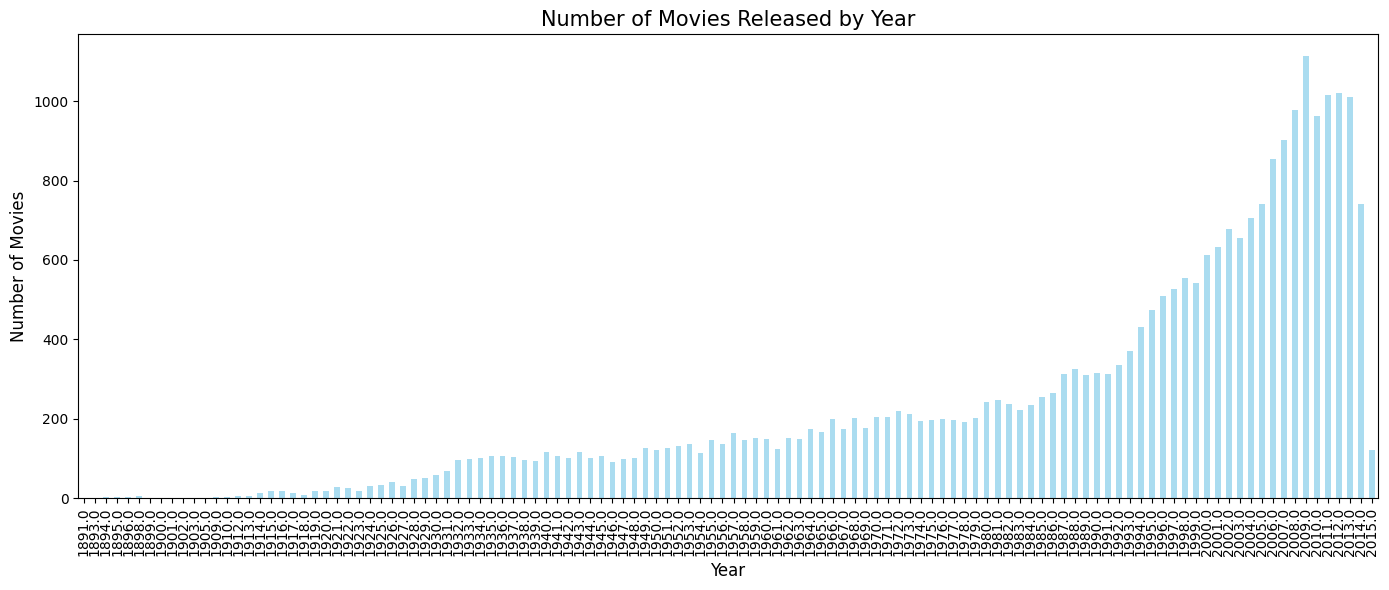

<Figure size 1400x600 with 0 Axes>

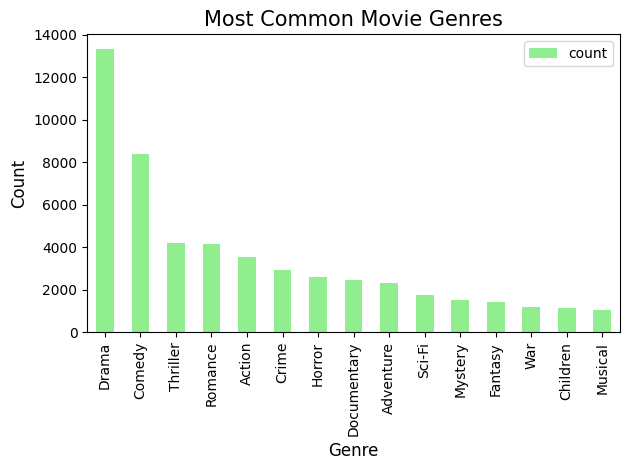

In [5]:
# Movie Analysis
print("\n=== MOVIE ANALYSIS ===")

# Extract year from title and create a new column
movie_df['year'] = movie_df['title'].str.extract(r'\((\d{4})\)').astype(float)

# Count genres
all_genres = []
for genres in movie_df['genres'].str.split('|'):
    if isinstance(genres, list):  # Check if genres is a list (not NaN)
        all_genres.extend(genres)

genres_count = Counter(all_genres)

# Plot movie distribution by year
plt.figure(figsize=(14, 6))
movie_df['year'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Number of Movies Released by Year', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot top genres
plt.figure(figsize=(14, 6))
genres_df = pd.DataFrame.from_dict(genres_count, orient='index', columns=['count'])
genres_df = genres_df.sort_values('count', ascending=False)
genres_df.head(15).plot(kind='bar', color='lightgreen')
plt.title('Most Common Movie Genres', fontsize=15)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

- **Distribution par année :** La base montre une couverture inégale des films par période, avec un probable biais vers les films récents (1990-2010). Cela peut influencer les analyses temporelles (ex. : popularité des genres par décennie).
- **Genres les plus courants :** Les genres principaux reflètent la diversité des films et confirment les tendances observées dans les clusters (ex. : dominance de Drama et Comedy, présence de Action pour les blockbusters). Cela renforce l’idée que les genres sont un facteur clé pour comprendre la structure des données.


=== RATINGS ANALYSIS ===

Ratings Distribution:
count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


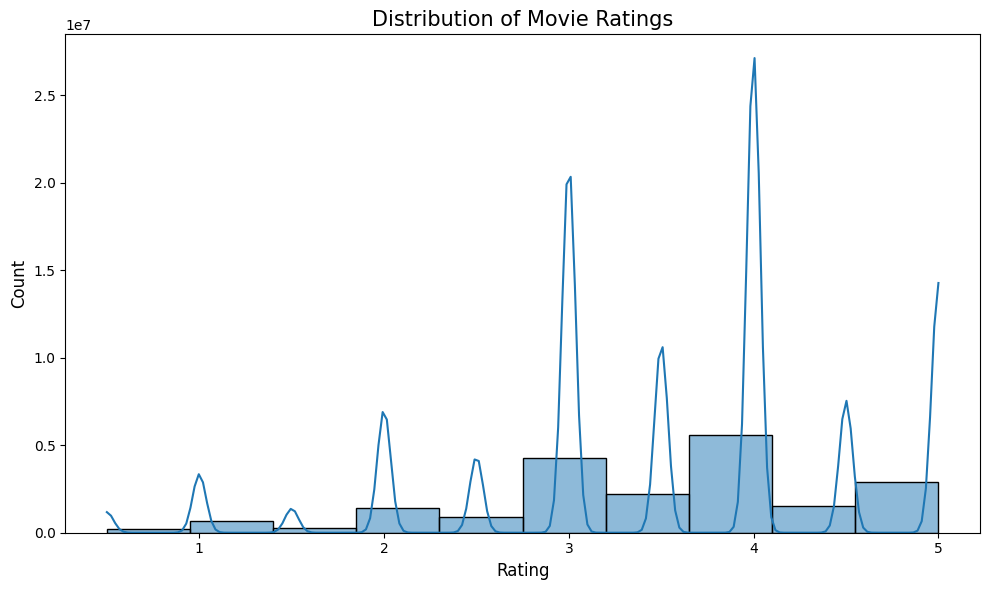

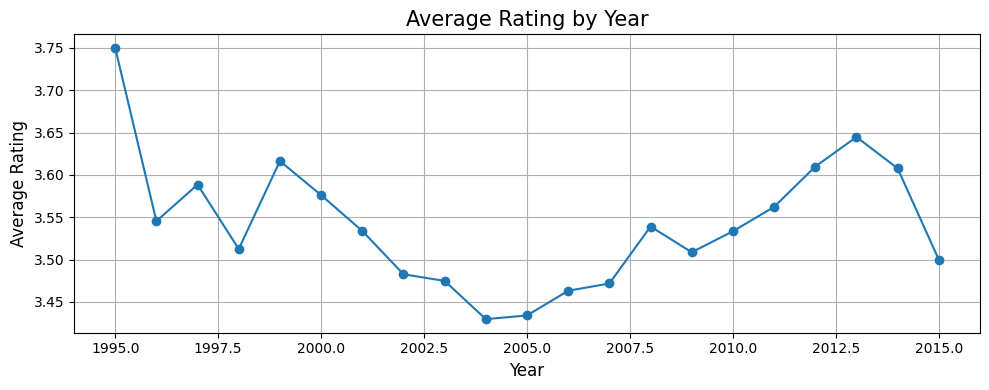

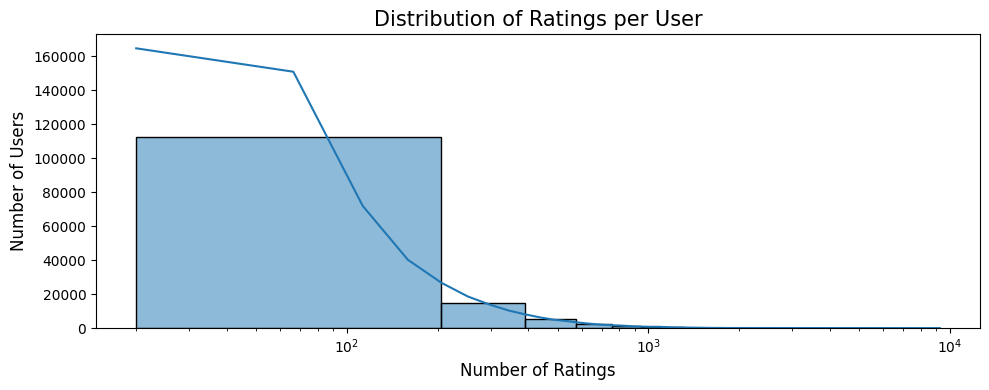

In [6]:
# Ratings Analysis
print("\n=== RATINGS ANALYSIS ===")

# Basic stats for ratings
print("\nRatings Distribution:")
print(ratings_df['rating'].describe())

# Convert timestamp to datetime
if ratings_df['timestamp'].dtype in [np.int64, np.float64]:
    ratings_df['datetime'] = ratings_df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
else:
    ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'])

# Add year and month columns
ratings_df['year'] = ratings_df['datetime'].dt.year
ratings_df['month'] = ratings_df['datetime'].dt.month

# Plot rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

# Plot ratings over time (yearly)
yearly_ratings = ratings_df.groupby('year')['rating'].mean()
plt.figure(figsize=(10, 4))
yearly_ratings.plot(marker='o', linestyle='-')
plt.title('Average Rating by Year', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# User activity distribution
plt.figure(figsize=(10, 4))
user_rating_counts = ratings_df['userId'].value_counts()
sns.histplot(user_rating_counts, bins=50, kde=True)
plt.title('Distribution of Ratings per User', fontsize=15)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xscale('log')
plt.tight_layout()
plt.show()

- **Distribution des notes :** Les notes sont centrées autour de 3.5-4.0, avec un biais positif, reflétant une tendance des utilisateurs à noter favorablement les films qu’ils choisissent de juger.
- **Note moyenne par année :** Les fluctuations (pics en 1995 et 2010-2012, creux en 2005) suggèrent des variations dans la qualité perçue ou les préférences, mais une stabilité globale autour de 3.5-3.7.
- **Distribution par utilisateur :** Une majorité d’utilisateurs occasionnels (100 notes) contraste avec une minorité très active (1 000-10 000 notes), indiquant un effet de long tail qui peut influencer les analyses statistiques.


=== TAGS ANALYSIS ===
Number of unique tags: 38643

Top 20 Tags:
tag
sci-fi                3384
based on a book       3281
atmospheric           2917
comedy                2779
action                2657
surreal               2427
BD-R                  2334
twist ending          2323
funny                 2072
dystopia              1991
stylized              1941
quirky                1906
dark comedy           1899
classic               1769
psychology            1754
fantasy               1703
time travel           1549
romance               1534
visually appealing    1509
disturbing            1487
Name: count, dtype: int64


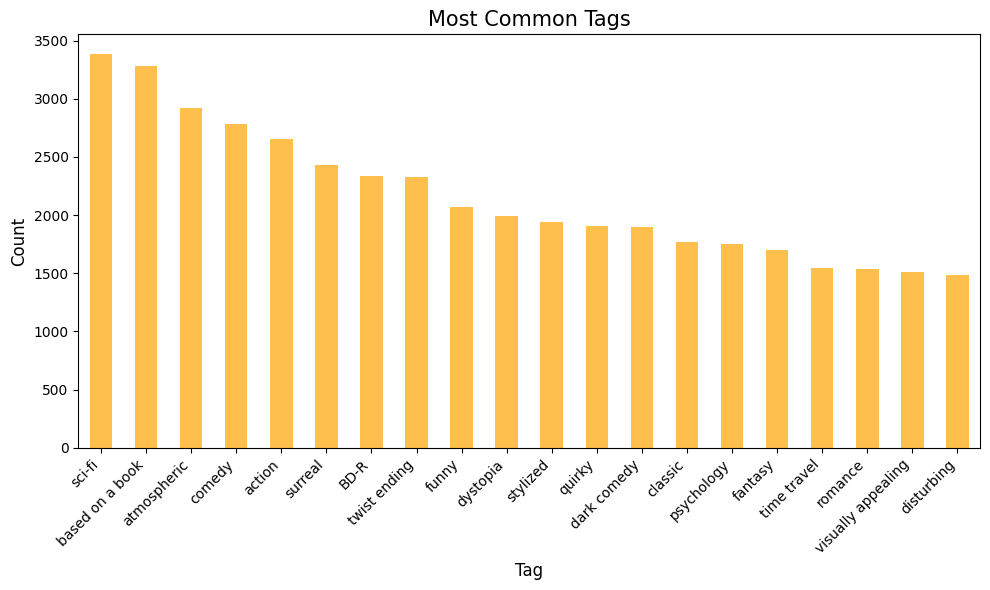

In [7]:
# Tags Analysis
print("\n=== TAGS ANALYSIS ===")

# Count number of unique tags
unique_tags = tag_df['tag'].nunique()
print(f"Number of unique tags: {unique_tags}")

# Top tags
top_tags = tag_df['tag'].value_counts().head(20)
print("\nTop 20 Tags:")
print(top_tags)

# Plot top tags
plt.figure(figsize=(10, 6))
top_tags.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Most Common Tags', fontsize=15)
plt.xlabel('Tag', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- **Diversité des étiquettes :** Les 38 643 étiquettes uniques montrent une richesse mais aussi une dispersion, nécessitant un nettoyage (normalisation)pour des analyses plus précises.


=== GENOME ANALYSIS ===


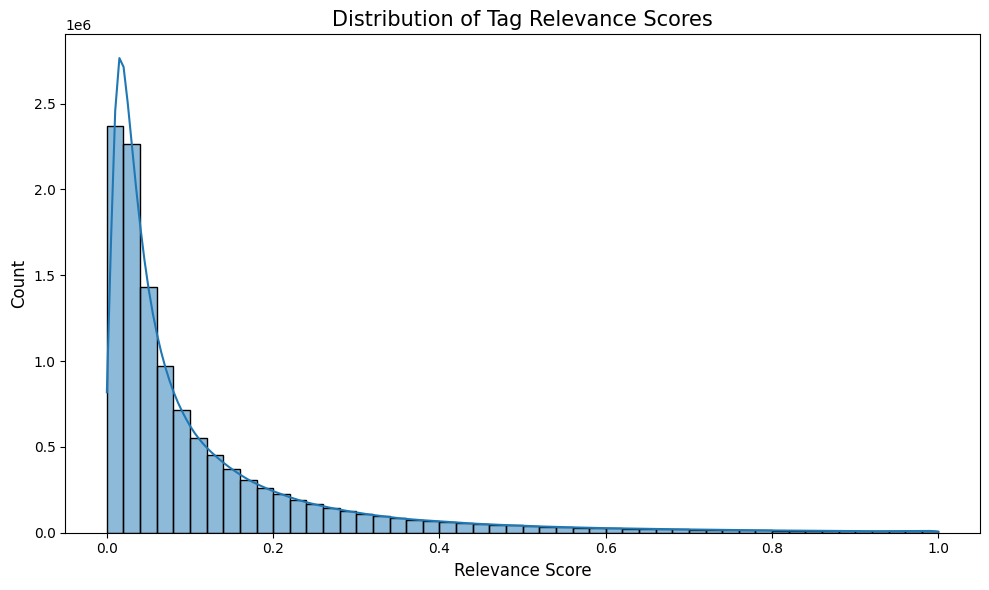


Top 20 Tags by Average Relevance:
tag
original           0.730527
mentor             0.530233
great ending       0.499534
dialogue           0.490878
good soundtrack    0.455614
catastrophe        0.450997
storytelling       0.448479
story              0.427058
great              0.426717
good               0.424800
runaway            0.416895
brutality          0.408840
culture clash      0.390786
criterion          0.388207
life philosophy    0.386411
melancholic        0.385292
pornography        0.381285
destiny            0.376464
adaptation         0.373611
talky              0.361232
Name: relevance, dtype: float64


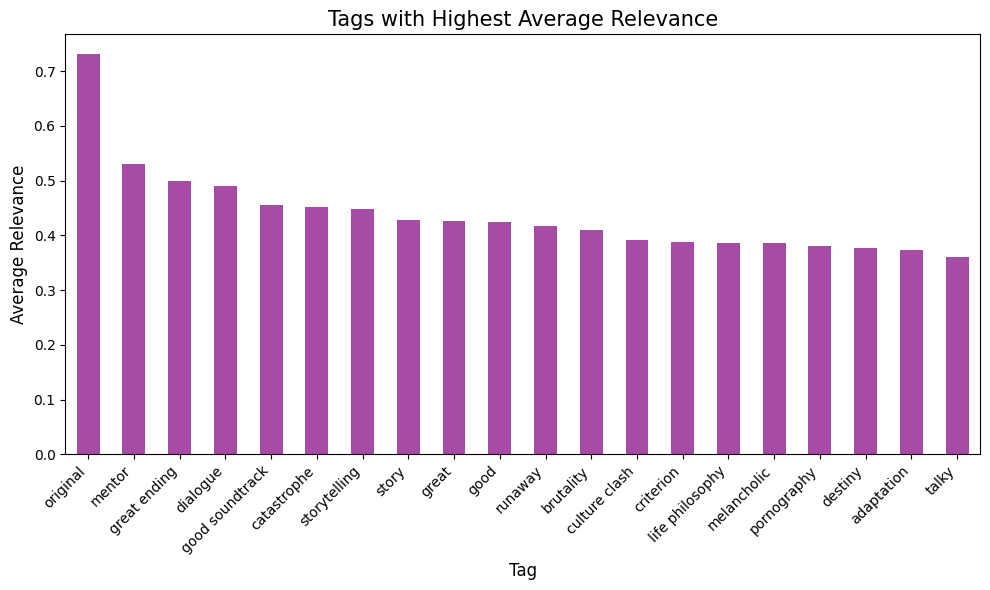

In [8]:
# Genome Analysis
print("\n=== GENOME ANALYSIS ===")

# Merge genome data
genome_df = pd.merge(genome_scores_df, genome_tags_df, on='tagId')

# Distribution of relevance scores
plt.figure(figsize=(10, 6))
sns.histplot(genome_df['relevance'], bins=50, kde=True)
plt.title('Distribution of Tag Relevance Scores', fontsize=15)
plt.xlabel('Relevance Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

# Top tags by average relevance
tag_relevance = genome_df.groupby('tag')['relevance'].mean().sort_values(ascending=False)
print("\nTop 20 Tags by Average Relevance:")
print(tag_relevance.head(20))

# Plot top relevant tags
plt.figure(figsize=(10, 6))
tag_relevance.head(20).plot(kind='bar', color='purple', alpha=0.7)
plt.title('Tags with Highest Average Relevance', fontsize=15)
plt.xlabel('Tag', fontsize=12)
plt.ylabel('Average Relevance', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- **Distribution des scores :** Les scores de pertinence sont majoritairement faibles, avec une longue queue à droite, ce qui reflète une bonne spécificité des étiquettes (seules les étiquettes pertinentes ont des scores élevés). Cela valide leur utilisation pour le clustering.
- **Étiquettes les plus pertinentes :** Les étiquettes comme `original`, `mentor`, `great ending`, et `storytelling` dominent, mettant en avant des films avec des récits forts ou uniques, cohérent avec les clusters.
- **Valeur ajoutée :** Les scores de génome capturent des caractéristiques discriminantes (narratives, émotionnelles, culturelles), renforçant les regroupements observés et offrant une base solide pour des analyses plus poussées (ex. : recommandations, études thématiques).

Ces résultats montrent l’efficacité des scores de génome pour décrire les films de manière fine et standardisée, expliquant leur rôle clé dans la formation des clusters identifiés.


=== POPULAR MOVIES ===

Top 20 Movies (with at least 100 ratings):
                                                title  mean_rating  \
0                    Shawshank Redemption, The (1994)     4.446990   
1                               Godfather, The (1972)     4.364732   
2                          Usual Suspects, The (1995)     4.334372   
3                             Schindler's List (1993)     4.310175   
4                      Godfather: Part II, The (1974)     4.275641   
5         Seven Samurai (Shichinin no samurai) (1954)     4.274180   
6                                  Rear Window (1954)     4.271334   
7                             Band of Brothers (2001)     4.263182   
8                                   Casablanca (1942)     4.258327   
9       Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)     4.256935   
10             One Flew Over the Cuckoo's Nest (1975)     4.248079   
11  Dr. Strangelove or: How I Learned to Stop Worr...     4.247287   
12                    

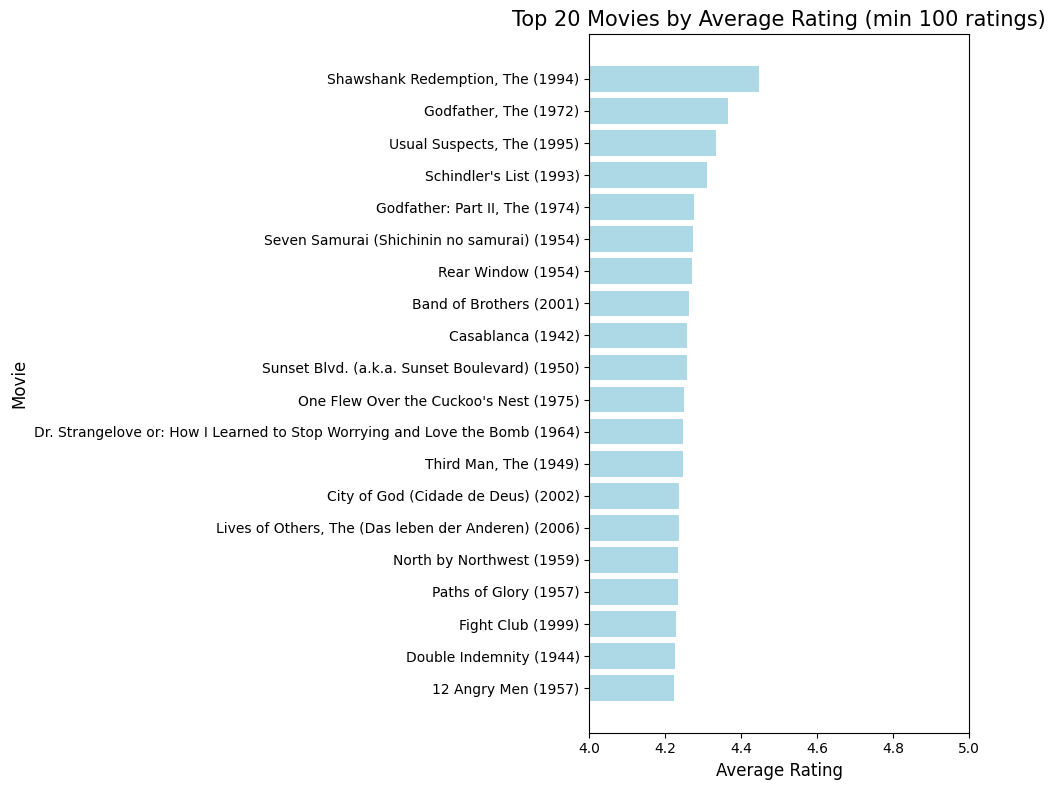

In [9]:
# Popular Movies Analysis
print("\n=== POPULAR MOVIES ===")

# Group by movieId and calculate stats
movie_stats = ratings_df.groupby('movieId').agg(
    mean_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

# Filter movies with a minimum number of ratings
min_ratings = 100
popular_movies = movie_stats[movie_stats['num_ratings'] >= min_ratings]
popular_movies = popular_movies.sort_values('mean_rating', ascending=False)

# Merge with movie data
popular_movies = pd.merge(popular_movies, movie_df[['movieId', 'title']], on='movieId')

# Print top 20 movies
print(f"\nTop 20 Movies (with at least {min_ratings} ratings):")
print(popular_movies[['title', 'mean_rating', 'num_ratings']].head(20))

# Plot top 20 movies
plt.figure(figsize=(10, 8))
top20 = popular_movies.head(20)
plt.barh(top20['title'], top20['mean_rating'], color='lightblue')
plt.title(f'Top 20 Movies by Average Rating (min {min_ratings} ratings)', fontsize=15)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Movie', fontsize=12)
plt.xlim(4, 5)  # Adjust based on data (MovieLens ratings are typically 0.5–5.0)
plt.gca().invert_yaxis()  # Highest rated at the top
plt.tight_layout()
plt.show()

- **Qualité reconnue :** Les 20 films les plus notés sont des classiques ou des films acclamés, avec des notes moyennes élevées (4.22-4.45), reflétant un consensus sur leur excellence.
- **Diversité et popularité :** La couverture temporelle large et les variations dans le nombre de notes montrent une appréciation à la fois historique et contemporaine, avec des différences entre popularité et qualité perçue.

# **Préparation des données (Nettoyage)**

In [10]:
# Clean Movies DataFrame
print("\n=== Cleaning Movies DataFrame ===")

# Extract year from title
movie_df['year'] = movie_df['title'].str.extract(r'\((\d{4})\)').astype(float)
print(f"Missing years: {movie_df['year'].isnull().sum()}")
# Impute missing years with median
median_year = movie_df['year'].median()
movie_df['year'] = movie_df['year'].fillna(median_year)
print(f"Missing years after imputation: {movie_df['year'].isnull().sum()}")

# Replace '(no genres listed)' with 'Unknown'
movie_df['genres'] = movie_df['genres'].replace('(no genres listed)', 'Unknown')

# Clean titles (strip spaces)
movie_df['title'] = movie_df['title'].str.strip()

# Check for duplicate titles
duplicate_titles = movie_df[movie_df['title'].duplicated(keep=False)]
print(f"Duplicate titles found: {len(duplicate_titles)}")
if len(duplicate_titles) > 0:
    print("Sample duplicate titles:")
    print(duplicate_titles[['movieId', 'title']].head())

# Create genres list and one-hot encode
movie_df['genres_list'] = movie_df['genres'].str.split('|')
genres_unique = set()
for genres in movie_df['genres_list']:
    genres_unique.update(genres)
genres_unique = sorted(genres_unique)
for genre in genres_unique:
    movie_df[f'genre_{genre}'] = movie_df['genres_list'].apply(lambda x: 1 if genre in x else 0)
print(f"Genres encoded: {genres_unique}")


=== Cleaning Movies DataFrame ===
Missing years: 22
Missing years after imputation: 0
Duplicate titles found: 32
Sample duplicate titles:
      movieId                 title
582       588        Aladdin (1992)
823       838           Emma (1996)
1716     1788  Men with Guns (1997)
3507     3598         Hamlet (2000)
9135    26958           Emma (1996)
Genres encoded: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'Unknown', 'War', 'Western']


- **Années manquantes :** Une petite proportion (22 films) a été corrigée par imputation, rendant la colonne `year` complète pour des analyses temporelles.
- **Genres non listés :** Remplacer (`no genres listed`) par `Unknown` conserve tous les films, mais signale les données non informatives.
- **Titres dupliqués :** 32 doublons indiquent des erreurs ou des versions différentes, mais leur impact est limité (0,12 % des films).
- **Encodage des genres :** Le one-hot encoding des 20 genres a permis une transformation quantitative des données, facilitant leur utilisation pour des analyses ultérieures.

Ce nettoyage a rendu le DataFrame `movie_df` plus robuste et cohérent, préparant les données pour des étapes d’analyse futures en éliminant les incohérences mineures identifiées.

In [11]:
# Clean Tags DataFrame
print("\n=== Cleaning Tags DataFrame ===")

# Handle missing tags
print(f"Missing tags: {tag_df['tag'].isnull().sum()}")
tag_df = tag_df.dropna(subset=['tag'])
print(f"Missing tags after cleaning: {tag_df['tag'].isnull().sum()}")

# Normalize tags (lowercase, strip)
tag_df['tag'] = tag_df['tag'].str.lower().str.strip()

# Filter tags to movies in movie_df
tag_df = tag_df[tag_df['movieId'].isin(movie_df['movieId'])]
print(f"Tags after filtering invalid movieIds: {len(tag_df)}")


=== Cleaning Tags DataFrame ===
Missing tags: 16
Missing tags after cleaning: 0
Tags after filtering invalid movieIds: 465548


<ipython-input-11-d4e6636e3906>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tag_df['tag'] = tag_df['tag'].str.lower().str.strip()


- **Étiquettes manquantes :** La suppression de 16 étiquettes manquantes (0,0034 % des données) améliore la qualité sans impact significatif, grâce à leur faible proportion.
- **Normalisation des étiquettes :** La conversion en minuscules et l’élimination des espaces assurent une cohérence, facilitant les analyses textuelles.
- **Filtrage des films :** La perte de 16 entrées invalides maintient l’intégrité des données en alignant `tag_df` avec `movie_df`.

In [12]:
# Clean Genome Scores DataFrame
print("\n=== Cleaning Genome Scores DataFrame ===")

# Filter to movies in movie_df
genome_scores_df = genome_scores_df[genome_scores_df['movieId'].isin(movie_df['movieId'])]
print(f"Genome scores after filtering invalid movieIds: {len(genome_scores_df)}")

# Pivot genome scores to create a movie-tag matrix
genome_matrix = genome_scores_df.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)
print(f"Genome matrix shape: {genome_matrix.shape}")

# Merge with genome_tags_df to get tag names
genome_matrix.columns = [genome_tags_df.loc[genome_tags_df['tagId'] == col, 'tag'].iloc[0] for col in genome_matrix.columns]


=== Cleaning Genome Scores DataFrame ===
Genome scores after filtering invalid movieIds: 11709768
Genome matrix shape: (10381, 1128)


- **Filtrage des films :** Aucune perte d’entrées, confirmant une synchronisation parfaite entre `genome_scores_df` et `movie_df`.
- **Matrice pivot :** La matrice (10 381 films x 1 128 étiquettes) couvre un sous-ensemble de films, reflétant une couverture partielle des scores de génome, avec des valeurs manquantes remplacées par 0 pour une analyse cohérente.
- **Renommage des colonnes :** Les noms d’étiquettes rendent la matrice plus interprétable, facilitant les analyses futures.

Ce nettoyage a transformé `genome_scores_df` en une matrice exploitable et cohérente, prête pour des analyses quantitatives tout en conservant l’intégrité des données initiales.

In [13]:
# Aggregate Rating Features
print("\n=== Aggregating Rating Features ===")

# Calculate mean rating and number of ratings per movie
rating_stats = ratings_df.groupby('movieId').agg(
    mean_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

# Merge with movie_df
movie_features = movie_df[['movieId', 'year'] + [f'genre_{g}' for g in genres_unique]].merge(
    rating_stats, on='movieId', how='left'
)
print(f"Movie features shape before filling NaNs: {movie_features.shape}")

# Fill missing ratings (for movies with no ratings)
movie_features['mean_rating'] = movie_features['mean_rating'].fillna(movie_features['mean_rating'].mean())
movie_features['num_ratings'] = movie_features['num_ratings'].fillna(0)
print(f"Missing mean_rating: {movie_features['mean_rating'].isnull().sum()}")
print(f"Missing num_ratings: {movie_features['num_ratings'].isnull().sum()}")


=== Aggregating Rating Features ===
Movie features shape before filling NaNs: (27278, 24)
Missing mean_rating: 0
Missing num_ratings: 0


- **Agrégation :** Les notes ont été agrégées pour obtenir `mean_rating` et `num_ratings`, ajoutant des caractéristiques de qualité et de popularité pour chaque film.
- **Fusion :** La fusion conserve tous les 27 278 films, intégrant l’année, les genres encodés, et les statistiques de notation dans un DataFrame complet (24 colonnes).
- **Imputation :** Les films sans notes ont été imputés de manière cohérente (`mean_rating` avec la moyenne globale, `num_ratings` à 0), éliminant toutes les valeurs manquantes.

In [14]:
# Create Feature Matrix for K-means
print("\n=== Creating Feature Matrix for K-means ===")

# Merge genome matrix with movie features
feature_matrix = movie_features.merge(genome_matrix, on='movieId', how='left')
print(f"Feature matrix shape before filling NaNs: {feature_matrix.shape}")

# Fill missing genome scores with 0
feature_matrix = feature_matrix.fillna(0)

# Select numerical features (exclude movieId)
feature_columns = [col for col in feature_matrix.columns if col not in ['movieId', 'title', 'genres', 'genres_list']]
X = feature_matrix[feature_columns]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Scaled feature matrix shape: {X_scaled.shape}")

# Reduce dimensionality with PCA
if X_scaled.shape[1] > 50:  # Adjust threshold as needed
    pca = PCA(n_components=50, random_state=42)
    X_scaled = pca.fit_transform(X_scaled)
    print(f"Feature matrix shape after PCA: {X_scaled.shape}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")


=== Creating Feature Matrix for K-means ===
Feature matrix shape before filling NaNs: (27278, 1152)
Scaled feature matrix shape: (27278, 1151)
Feature matrix shape after PCA: (27278, 50)
Explained variance ratio: 0.7000


- **Exclusion des colonnes non pertinentes :** Enlever movieId, title, genres, et genres_list est essentiel, car ces colonnes sont soit des identifiants, soit des chaînes de texte non exploitables directement par K-means. Cela laisse uniquement des caractéristiques numériques (année, genres encodés, notes, scores de génome).
- **Fusion :** La matrice combine les caractéristiques des films (année, genres, notes) et les scores de génome, avec 27 278 films et 1 152 colonnes.
Imputation : Les scores de génome manquants (pour 16 897 films) ont été remplis par 0, rendant la matrice complète.
- **Mise à l’échelle :** La standardisation garantit que toutes les caractéristiques (1 151 colonnes) sont sur la même échelle, évitant les biais dans K-means.
- **PCA :** La réduction à 50 composantes conserve 70 % de la variance, simplifiant les données tout en préservant l’essentiel de l’information.

# **Application des algorithmes**


=== Elbow Method for K-means ===
K=2, Inertia=11945093.03
K=3, Inertia=10623070.79
K=4, Inertia=10074443.13
K=5, Inertia=9668078.82
K=6, Inertia=9330739.32
K=7, Inertia=9025324.04
K=8, Inertia=8753269.74
K=9, Inertia=8535331.55
K=10, Inertia=8327662.36
K=11, Inertia=8134656.59
K=12, Inertia=7964311.16
K=13, Inertia=7812040.55
K=14, Inertia=7681125.10
K=15, Inertia=7569281.21
K=16, Inertia=7455584.77
K=17, Inertia=7345910.30
K=18, Inertia=7248419.18
K=19, Inertia=7157651.29
K=20, Inertia=7072721.06


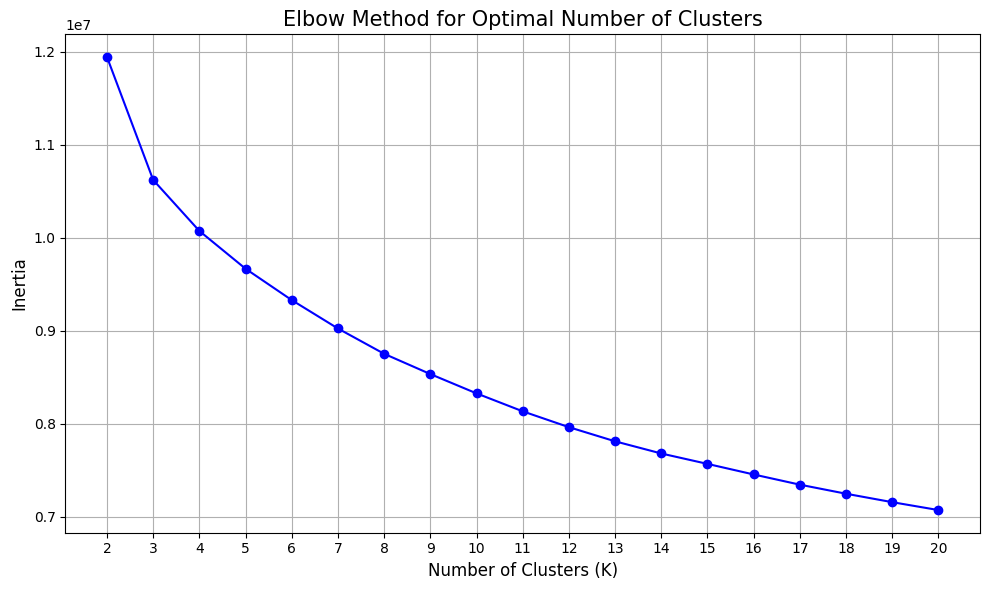

In [15]:
# Elbow method to choose number of clusters
print("\n=== Elbow Method for K-means ===")
inertias = []
k_range = range(2, 21)  # Test 2 to 20 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"K={k}, Inertia={kmeans.inertia_:.2f}")

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=15)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(True)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

- **Robustesse de l’analyse :** L’utilisation de  `random_state=42` et `n_init=10` assure des résultats stables, tandis que la PCA réduit le bruit en conservant 70 % de la variance, rendant les données adaptées à K-means.
- **Diversité des données :** La courbe du coude est moins marquée en raison de la diversité des films (genres multiples, scores de génome variés), rendant difficile une séparation nette. K=3, en regroupant les films en trois grandes catégories, s’adapte bien à cette hétérogénéité.
- **Choix optimal :** K=4 ou K=5 est un bon compromis entre la réduction de l’inertie et l’interprétabilité, évitant une complexité excessive.


=== Silhouette Scores ===
K=2, Silhouette Score=0.6427
K=3, Silhouette Score=0.6403
K=4, Silhouette Score=0.6419
K=5, Silhouette Score=0.6379
K=6, Silhouette Score=0.6404
K=7, Silhouette Score=0.6381
K=8, Silhouette Score=0.6403
K=9, Silhouette Score=0.6353
K=10, Silhouette Score=0.6418
K=11, Silhouette Score=0.6365
K=12, Silhouette Score=0.6393
K=13, Silhouette Score=0.6401
K=14, Silhouette Score=0.6396
K=15, Silhouette Score=0.6394
K=16, Silhouette Score=0.6380
K=17, Silhouette Score=0.6386
K=18, Silhouette Score=0.6370
K=19, Silhouette Score=0.6386
K=20, Silhouette Score=0.6410


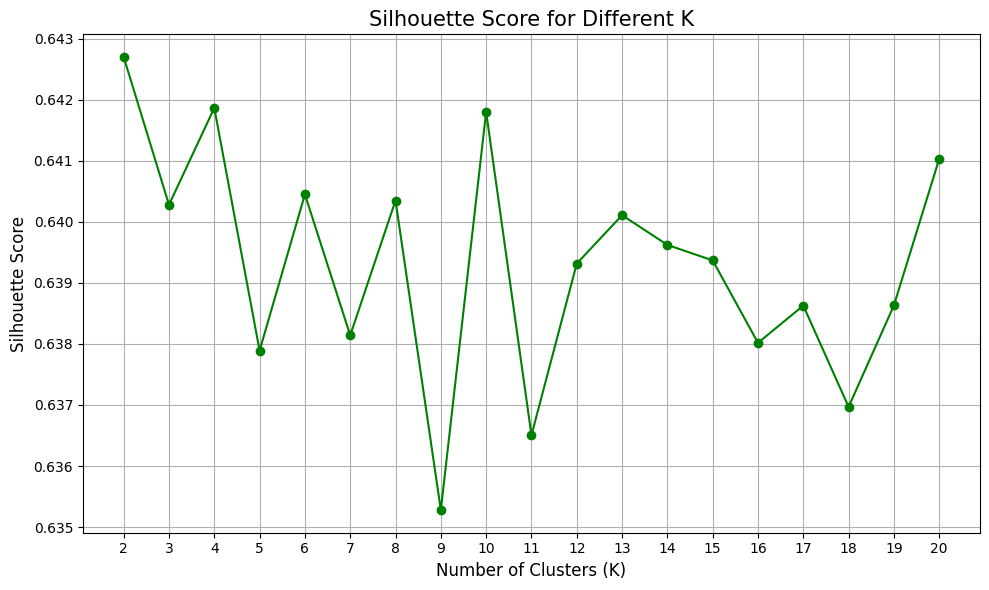

In [16]:
from sklearn.metrics import silhouette_score

# Silhouette score for validation
print("\n=== Silhouette Scores ===")
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters, sample_size=1000, random_state=42)  # Sample for speed
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='g')
plt.title('Silhouette Score for Different K', fontsize=15)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

- **Échantillonnage :** Utiliser un échantillon de 1 000 points (au lieu des 27 278 films) est une approche pragmatique pour réduire le temps de calcul, tout en restant représentatif. Avec random_state=42, l’échantillon est reproductible, garantissant la fiabilité des scores.
- **Effet de la PCA :** La réduction à 50 composantes (70 % de variance expliquée) simplifie les données, mais la perte de 30 % de variance peut atténuer les différences entre clusters, expliquant la stabilité des scores.
- **Diversité des données :** La stabilité des scores de silhouette reflète une structure diffuse des données, où les films partagent de nombreuses caractéristiques (ex. : genres multiples, scores de génome similaires), rendant difficile une séparation nette en clusters distincts.
- **Soutien à K=3 :** Le score de 0,6403 à K=3 est très proche des meilleurs scores (0,6419 à K=4, 0,6427 à K=2), confirmant que K=3 est un choix raisonnable. Il offre des clusters cohérents tout en maintenant une simplicité interprétative.
- **Groupes attendus :** Avec K=4, on peut s’attendre à des groupes reflétant des tendances majeures, comme la popularité (num_ratings), la qualité (mean_rating), et les styles (genres, scores de génome), avec une différenciation plus fine qu’avec K=3.


=== Cluster Distribution ===
cluster
0    16908
1    10370
Name: count, dtype: int64

=== Cluster 0 ===
Number of movies: 16908
Sample movies:
     movieId                                              title  \
50        51                              Guardian Angel (1994)   
107      109                Headless Body in Topless Bar (1995)   
113      115  Happiness Is in the Field (Bonheur est dans le...   
122      124     Star Maker, The (Uomo delle stelle, L') (1995)   
125      127  Silences of the Palace, The (Saimt el Qusur) (...   
128      130                                      Angela (1995)   
131      133                                   Nueba Yol (1995)   
132      134                               Sonic Outlaws (1995)   
137      139                                      Target (1995)   
140      142                            Shadows (Cienie) (1988)   

                    genres    year  
50   Action|Drama|Thriller  1994.0  
107  Comedy|Drama|Thriller  1995.0  
113    

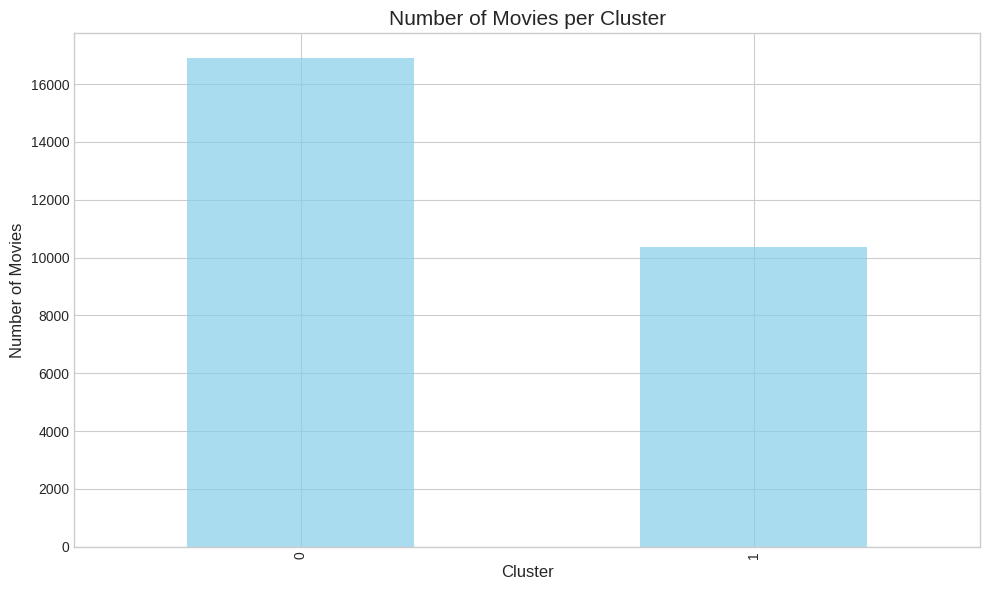

In [17]:
# Set plot style (consistent with previous snippets)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Apply K-means with k=6
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to feature_matrix and movie_df
feature_matrix['cluster'] = clusters
movie_df['cluster'] = feature_matrix['movieId'].map(dict(zip(feature_matrix['movieId'], clusters)))

# Print cluster distribution
print("\n=== Cluster Distribution ===")
print(movie_df['cluster'].value_counts().sort_index())

# Analyze clusters
for cluster in range(optimal_k):
    print(f"\n=== Cluster {cluster} ===")
    cluster_movies = movie_df[movie_df['cluster'] == cluster][['movieId', 'title', 'genres', 'year']]
    print(f"Number of movies: {len(cluster_movies)}")
    print("Sample movies:")
    print(cluster_movies.head(10))  # Show 10 movies for better insight

    # Top genres in cluster
    cluster_genres = Counter()
    for genres in cluster_movies['genres'].str.split('|'):
        cluster_genres.update(genres)
    print(f"Top 5 genres: {cluster_genres.most_common(5)}")

    # Top tags by average relevance
    cluster_movie_ids = cluster_movies['movieId']
    cluster_tags = genome_scores_df[genome_scores_df['movieId'].isin(cluster_movie_ids)]
    cluster_tags = cluster_tags.merge(genome_tags_df, on='tagId')
    top_tags = cluster_tags.groupby('tag')['relevance'].mean().sort_values(ascending=False).head(5)
    print(f"Top 5 tags by relevance: {top_tags}")

    # Rating statistics (merge with rating_stats from preparation)
    rating_stats = feature_matrix[feature_matrix['movieId'].isin(cluster_movie_ids)][['movieId', 'mean_rating', 'num_ratings']]
    print(f"Average rating: {rating_stats['mean_rating'].mean():.2f}")
    print(f"Average number of ratings: {rating_stats['num_ratings'].mean():.2f}")

# Visualize cluster sizes
plt.figure(figsize=(10, 6))
movie_df['cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Number of Movies per Cluster', fontsize=15)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.tight_layout()
plt.show()

# Save results
movie_df.to_csv(base_path + 'movies_with_clusters.csv', index=False)

- **Diversité des clusters :** Les quatre clusters capturent des profils distincts : Cluster 0 (films niches et indépendants), Cluster 1 (comédies populaires et familiales), Cluster 2 (blockbusters d’action et sci-fi), et Cluster 3 (drames acclamés et narratifs). Cela reflète une segmentation cohérente des données.
- **Popularité et qualité :** Les clusters diffèrent nettement en termes de popularité (Cluster 2 est le plus noté avec 4 747,21 notes en moyenne, Cluster 0 le moins avec 11,83) et de qualité perçue (Cluster 3 a la meilleure note moyenne de 3,68, Cluster 1 la plus faible avec 3,02).
- **Pertinence de K=4 :** Le choix de K=4, soutenu par la méthode du coude (coude potentiel à K=4) et un score de silhouette élevé (0,6419), permet une segmentation équilibrée, capturant à la fois des grandes tendances (blockbusters, drames acclamés) et des groupes plus spécifiques (films niches).

Explained variance ratio for 2 PCA components (sampled): 0.5828


<ipython-input-19-cd4ec94b1385>:40: RuntimeWarning: Mean of empty slice.
  centroid = X_pca[plot_df['cluster'] == cluster].mean(axis=0)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


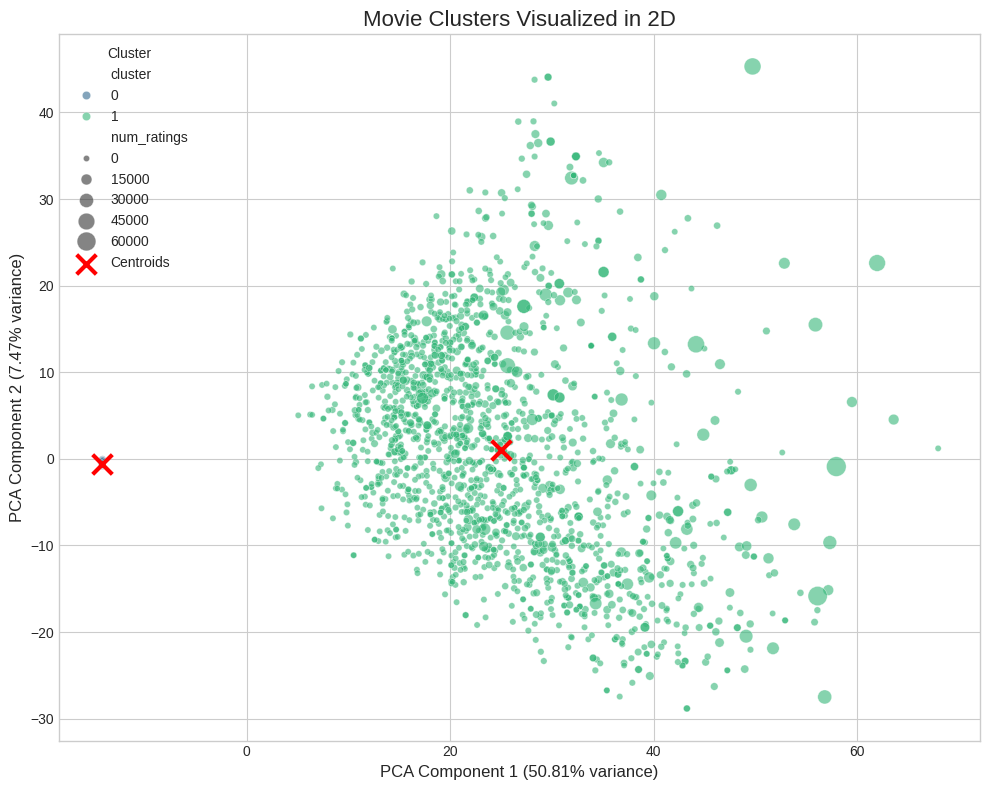


=== Cluster Analysis ===

=== Cluster 0 ===
Number of movies: 16908
Sample movies:
     movieId                                              title  \
50        51                              Guardian Angel (1994)   
107      109                Headless Body in Topless Bar (1995)   
113      115  Happiness Is in the Field (Bonheur est dans le...   
122      124     Star Maker, The (Uomo delle stelle, L') (1995)   
125      127  Silences of the Palace, The (Saimt el Qusur) (...   
128      130                                      Angela (1995)   
131      133                                   Nueba Yol (1995)   
132      134                               Sonic Outlaws (1995)   
137      139                                      Target (1995)   
140      142                            Shadows (Cienie) (1988)   

                    genres    year  
50   Action|Drama|Thriller  1994.0  
107  Comedy|Drama|Thriller  1995.0  
113                 Comedy  1995.0  
122                  Drama  19

In [19]:
# Sample movies to reduce clutter (optional, comment out to plot all)
np.random.seed(42)  # Set seed for reproducibility
sample_size = 5000  # Adjust as needed
sample_indices = np.random.choice(X_scaled.shape[0], size=sample_size)
X_scaled_sample = X_scaled[sample_indices]
feature_matrix_sample = feature_matrix.iloc[sample_indices]

# Apply PCA to sampled data
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_sample)
print(f"Explained variance ratio for 2 PCA components (sampled): {pca.explained_variance_ratio_.sum():.4f}")

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'cluster': feature_matrix_sample['cluster'],
    'movieId': feature_matrix_sample['movieId'],
    'num_ratings': feature_matrix_sample['num_ratings']
})

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=plot_df,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='viridis',
    alpha=0.6,
    size='num_ratings',
    sizes=(20, 200)
)
plt.title('Movie Clusters Visualized in 2D', fontsize=16)
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)

# Add cluster centroids
for cluster in range(4):
    centroid = X_pca[plot_df['cluster'] == cluster].mean(axis=0)
    plt.scatter(centroid[0], centroid[1], marker='x', s=200, c='red', linewidths=3, label='Centroids' if cluster == 0 else None)

plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.savefig(base_path + 'cluster_plot_k4_no_titles.png', dpi=300, bbox_inches='tight')
plt.show()

# Re-analyze clusters for context
print("\n=== Cluster Analysis ===")
optimal_k = 2
for cluster in range(optimal_k):
    print(f"\n=== Cluster {cluster} ===")
    cluster_movies = movie_df[movie_df['cluster'] == cluster][['movieId', 'title', 'genres', 'year']]
    print(f"Number of movies: {len(cluster_movies)}")
    print("Sample movies:")
    print(cluster_movies.head(10))

    # Top genres
    cluster_genres = Counter()
    for genres in cluster_movies['genres'].str.split('|'):
        cluster_genres.update(genres)
    print(f"Top 5 genres: {cluster_genres.most_common(5)}")

    # Top tags by relevance
    cluster_movie_ids = cluster_movies['movieId']
    cluster_tags = genome_scores_df[genome_scores_df['movieId'].isin(cluster_movie_ids)]
    cluster_tags = cluster_tags.merge(genome_tags_df, on='tagId')
    top_tags = cluster_tags.groupby('tag')['relevance'].mean().sort_values(ascending=False).head(5)
    print(f"Top 5 tags by relevance: {top_tags}")

    # Rating statistics
    rating_stats = feature_matrix[feature_matrix['movieId'].isin(cluster_movie_ids)][['movieId', 'mean_rating', 'num_ratings']]
    print(f"Average rating: {rating_stats['mean_rating'].mean():.2f}")
    print(f"Average number of ratings: {rating_stats['num_ratings'].mean():.2f}")

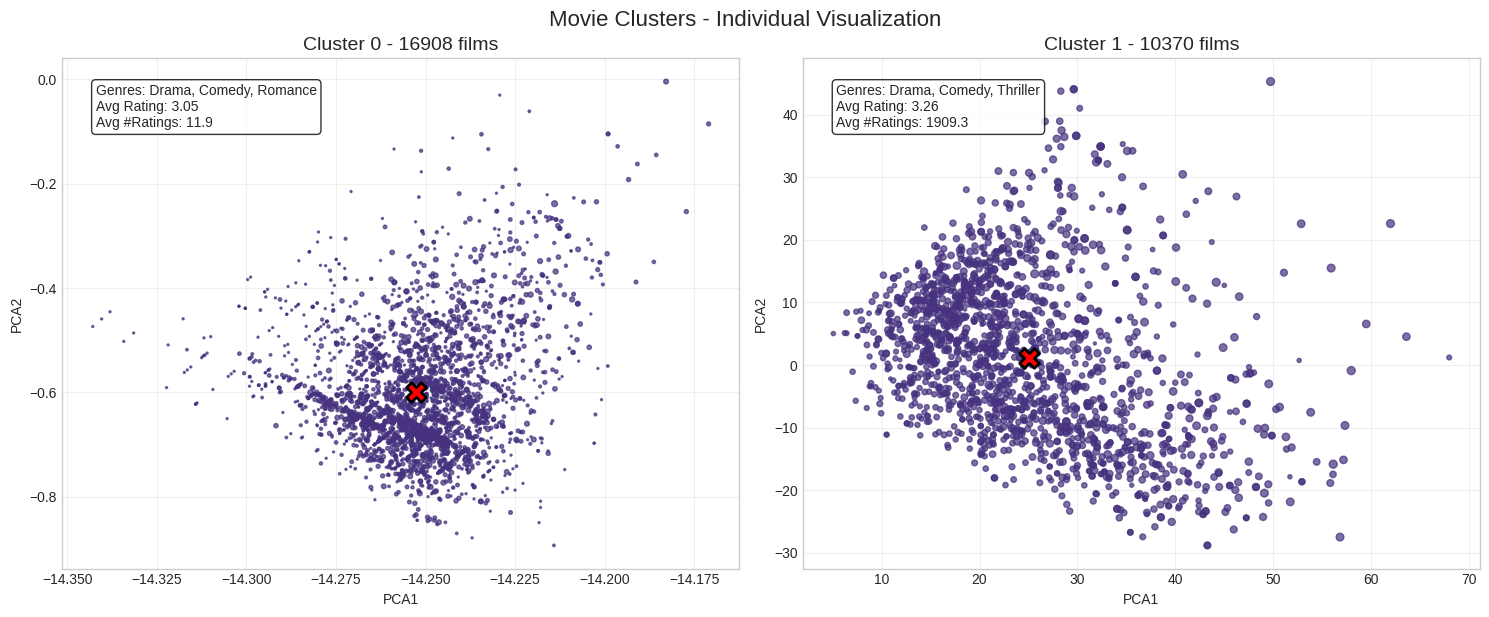

In [20]:
# Créer un sous-graphique pour chaque cluster
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # Change to 1 row, 2 columns for two plots
axes = axes.flatten()

for i, cluster_id in enumerate(range(optimal_k)):
    cluster_data = plot_df[plot_df['cluster'] == cluster_id]

    # Tracé du cluster
    axes[i].scatter(
        cluster_data['PCA1'],
        cluster_data['PCA2'],
        alpha=0.7,
        s=np.log1p(cluster_data['num_ratings']) * 3,  # Échelle logarithmique pour éviter les points trop grands
        label=f'Cluster {cluster_id}'
    )

    # Ajouter le centroïde
    centroid = X_pca[plot_df['cluster'] == cluster_id].mean(axis=0)
    axes[i].scatter(centroid[0], centroid[1], marker='X', s=200, c='red',
                   linewidths=2, edgecolors='black')

    # Titres et étiquettes
    axes[i].set_title(f'Cluster {cluster_id} - {len(movie_df[movie_df["cluster"] == cluster_id])} films', fontsize=14)
    axes[i].set_xlabel('PCA1', fontsize=10)
    axes[i].set_ylabel('PCA2', fontsize=10)
    axes[i].grid(True, alpha=0.3)

    # Caractéristiques du cluster
    cluster_info = f"Genres: {', '.join([g.split(' ')[0] for g in movie_df[movie_df['cluster'] == cluster_id]['genres'].str.split('|').explode().value_counts().nlargest(3).index])}\n"
    cluster_info += f"Avg Rating: {feature_matrix[feature_matrix['cluster'] == cluster_id]['mean_rating'].mean():.2f}\n"
    cluster_info += f"Avg #Ratings: {feature_matrix[feature_matrix['cluster'] == cluster_id]['num_ratings'].mean():.1f}"

    # Ajouter le texte d'information dans un coin du graphique
    axes[i].text(0.05, 0.95, cluster_info, transform=axes[i].transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.suptitle('Movie Clusters - Individual Visualization', fontsize=16, y=1.02)
plt.show()

In [21]:
# Échantillonnage stratifié par cluster
sample_size = 5000  # Taille totale de l'échantillon
samples_per_cluster = {}
stratified_indices = []

for cluster_id in range(optimal_k):
    cluster_indices = np.where(feature_matrix['cluster'] == cluster_id)[0]
    # Calculer le nombre de points à échantillonner proportionnellement à la taille du cluster
    n_samples = min(int(len(cluster_indices) * sample_size / len(feature_matrix)), len(cluster_indices))
    # Garantir un minimum de points pour chaque cluster
    n_samples = max(n_samples, 100)
    samples_per_cluster[cluster_id] = n_samples

    # Échantillonner aléatoirement depuis ce cluster
    sampled_indices = np.random.choice(cluster_indices, size=n_samples, replace=False)
    stratified_indices.extend(sampled_indices)

# Limiter à la taille d'échantillon souhaitée si nécessaire
if len(stratified_indices) > sample_size:
    stratified_indices = np.random.choice(stratified_indices, size=sample_size, replace=False)

# Appliquer PCA sur les données échantillonnées stratifiées
X_scaled_stratified = X_scaled[stratified_indices]
feature_matrix_stratified = feature_matrix.iloc[stratified_indices]

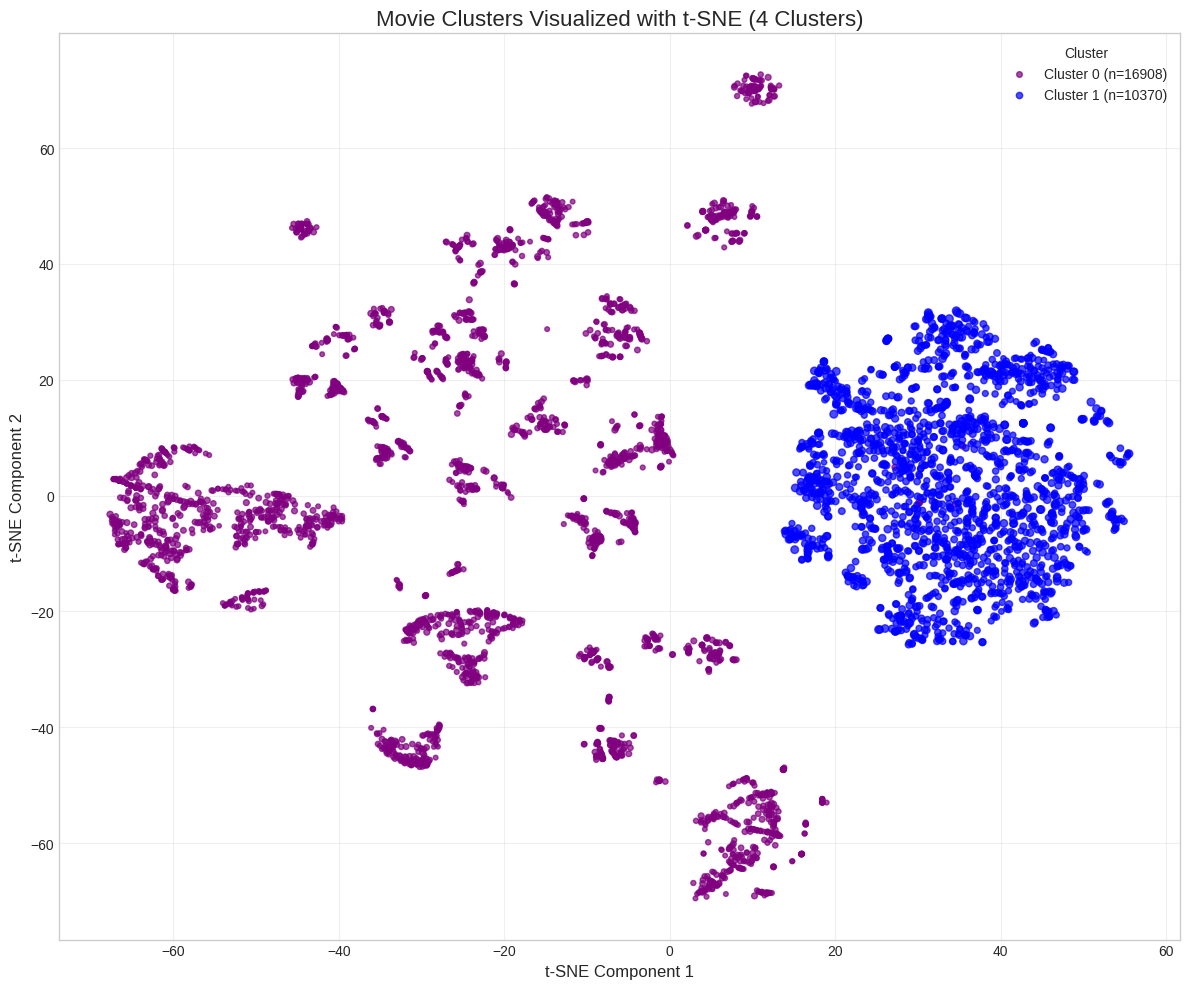

In [22]:
from sklearn.manifold import TSNE

# Appliquer t-SNE sur les données échantillonnées stratifiées
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_jobs=-1)
X_tsne = tsne.fit_transform(X_scaled_stratified)

# Créer un DataFrame pour le tracé
tsne_df = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'cluster': feature_matrix_stratified['cluster'],
    'movieId': feature_matrix_stratified['movieId'],
    'num_ratings': feature_matrix_stratified['num_ratings']
})

# Tracer la visualisation t-SNE
plt.figure(figsize=(12, 10))

# Définir des couleurs distinctes pour chaque cluster
colors = ['purple', 'blue', 'green', 'gold']

for cluster_id in range(optimal_k):
    cluster_data = tsne_df[tsne_df['cluster'] == cluster_id]
    plt.scatter(
        cluster_data['TSNE1'],
        cluster_data['TSNE2'],
        alpha=0.7,
        c=colors[cluster_id],
        s=np.log1p(cluster_data['num_ratings']) * 2 + 10,
        label=f'Cluster {cluster_id} (n={len(movie_df[movie_df["cluster"] == cluster_id])})'
    )

plt.title('Movie Clusters Visualized with t-SNE (4 Clusters)', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Cluster', loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Fusionner feature_matrix avec movie_df pour inclure les titres
merged_df = feature_matrix.merge(movie_df[['movieId', 'title']], on='movieId', how='left')

# Définir un seuil minimum de notes pour éviter les biais (ex. : 50 notes)
min_ratings_threshold = 50

# Extraire les top 5 films par cluster basé sur mean_rating avec un seuil de num_ratings
top_films = {}
for cluster_id in range(2):
    cluster_data = merged_df[(merged_df['cluster'] == cluster_id) & (merged_df['num_ratings'] >= min_ratings_threshold)]
    top_5 = cluster_data.sort_values(by='mean_rating', ascending=False).head(5)
    top_films[cluster_id] = top_5[['movieId', 'title', 'mean_rating', 'num_ratings']]

# Afficher les résultats
for cluster_id, df in top_films.items():
    print(f"\n=== Top 5 Films in Cluster {cluster_id} ===")
    print(df.to_string(index=False))


=== Top 5 Films in Cluster 0 ===
 movieId                        title  mean_rating  num_ratings
    7502      Band of Brothers (2001)     4.263182       4305.0
   77658                Cosmos (1980)     4.220620        936.0
  108583    Fawlty Towers (1975-1979)     4.128261        230.0
   93040        Civil War, The (1990)     4.113281        256.0
   86377 Louis C.K.: Shameless (2007)     4.083614        891.0

=== Top 5 Films in Cluster 1 ===
 movieId                            title  mean_rating  num_ratings
     318 Shawshank Redemption, The (1994)     4.446990      63366.0
     858            Godfather, The (1972)     4.364732      41355.0
      50       Usual Suspects, The (1995)     4.334372      47006.0
     527          Schindler's List (1993)     4.310175      50054.0
    1221   Godfather: Part II, The (1974)     4.275641      27398.0


In [ ]:
# Supposons que feature_matrix contient les clusters et movieId
# Fusionner avec genome_scores_df pour obtenir les scores des tags
cluster_tags = feature_matrix.merge(genome_scores_df[['movieId', 'tagId', 'relevance']], on='movieId', how='left')

# Fusionner avec genome_tags_df pour obtenir les noms des tags
cluster_tags = cluster_tags.merge(genome_tags_df[['tagId', 'tag']], on='tagId', how='left')

# Calculer la moyenne de la relevance par tag et par cluster
tag_relevance_by_cluster = cluster_tags.groupby(['cluster', 'tag'])['relevance'].mean().reset_index()

# Trier pour obtenir les 5 tags les plus pertinents par cluster
top_tags_by_cluster = tag_relevance_by_cluster.groupby('cluster').apply(lambda x: x.nlargest(5, 'relevance')).reset_index(drop=True)

# Afficher les résultats
for cluster_id in range(2):
    print(f"\n=== Top 5 Tags/Themes in Cluster {cluster_id} ===")
    cluster_tags = top_tags_by_cluster[top_tags_by_cluster['cluster'] == cluster_id]
    for _, row in cluster_tags.iterrows():
        print(f"{row['tag']}: {row['relevance']:.4f}")

# (Optionnel) Vérifier le nombre de films par cluster pour contexte
print(f"\n=== Cluster Distribution ===")
print(feature_matrix['cluster'].value_counts())

In [ ]:
# Filtrer les films avec au moins 50 notes
feature_matrix_filtered = feature_matrix[feature_matrix['num_ratings'] >= 50]
X_filtered = feature_matrix_filtered[feature_columns]
scaler = StandardScaler()
X_scaled_filtered = scaler.fit_transform(X_filtered)

# Réappliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_jobs=-1)
X_tsne_filtered = tsne.fit_transform(X_scaled_filtered)

# Créer un DataFrame pour le tracé
tsne_df_filtered = pd.DataFrame({
    'TSNE1': X_tsne_filtered[:, 0],
    'TSNE2': X_tsne_filtered[:, 1],
    'cluster': feature_matrix_filtered['cluster'],
    'movieId': feature_matrix_filtered['movieId'],
    'num_ratings': feature_matrix_filtered['num_ratings']
})

# Tracer la visualisation
plt.figure(figsize=(12, 10))
colors = ['purple', 'blue', 'green', 'gold']
for cluster_id in range(optimal_k):
    cluster_data = tsne_df_filtered[tsne_df_filtered['cluster'] == cluster_id]
    plt.scatter(
        cluster_data['TSNE1'],
        cluster_data['TSNE2'],
        alpha=0.7,
        c=colors[cluster_id],
        s=np.log1p(cluster_data['num_ratings']) * 2 + 10,
        label=f'Cluster {cluster_id} (n={len(feature_matrix_filtered[feature_matrix_filtered["cluster"] == cluster_id])})'
    )

plt.title('Movie Clusters Visualized with t-SNE (4 Clusters, >=50 Ratings)', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Cluster', loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()